In [1]:
install.packages('DT')
install.packages("bigrquery")

also installing the dependencies ‘lazyeval’, ‘crosstalk’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘rapidjsonr’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
install.packages("plotly")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [3]:
library(tidyverse)
library(DBI)
library(stringr)
library(DT)
library(lubridate)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
library(plotly)


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout




In [5]:
library(reshape2)


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




In [6]:
con <- dbConnect(
  bigrquery::bigquery(),
  project = "cal-itp-data-infra" ,
  dataset = "mart_gtfs" #,
#  billing = "billing"
  )

### Overall Route Name Failure 

#### Reading in the Bus file

In [7]:
Bus1 =  read_csv("../fs_kit/data/Bus1.csv") %>% 
    mutate(Bus = as.character(Bus))
head(Bus1)

Rows: 55 Columns: 2
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (2): Bus, deviceSerialNumber

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Bus,deviceSerialNumber
<chr>,<dbl>
5501,7805833
5121,7805871
5120,7805872
5119,7805870
5118,7805873
5117,7805869


#### Reading in the November 2023 XML file

In [8]:
SolTransNov23 = read_csv("../fs_kit/data/20231100009.000000.csv", col_select = c(
  operatorId,
  deviceSerialNumber,
  routeId,
  PST,
  recordType,
  fareTransactionSubType,
  contractId,
  productCategory,
  purseAmount,
  purseBalance,
  fareCategory,
  transferOperator,
  transferDiscountFlag,
  fareDiscount,
  deviceEventTransactionSubType,
  eventCode1 = eventCode33,
  eventCode16 = eventCode,
  # Description,
  routeId30)
)

Rows: 107107 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): PST
dbl (17): operatorId, deviceSerialNumber, routeId, recordType, fareTransacti...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
head(SolTransNov23)

operatorId,deviceSerialNumber,routeId,PST,recordType,fareTransactionSubType,contractId,productCategory,purseAmount,purseBalance,fareCategory,transferOperator,transferDiscountFlag,fareDiscount,deviceEventTransactionSubType,eventCode1,eventCode16,routeId30
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,7806092,436,11/1/2023 7:20,1,1,0,1,200,2190,0,0,0,NA,NA,NA,NA,NA
9,7806107,431,11/1/2023 7:06,1,1,0,1,0,2390,0,9,1,NA,NA,NA,NA,NA
9,7806092,436,11/1/2023 6:22,1,1,0,1,200,2390,0,0,0,NA,NA,NA,NA,NA
9,7805820,816,11/1/2023 15:35,1,1,0,1,500,5079,0,0,0,NA,NA,NA,NA,NA
9,7805837,835,11/1/2023 5:07,1,1,916,4,0,1645,0,0,0,NA,NA,NA,NA,NA
9,7805837,781,11/1/2023 15:30,1,1,916,4,0,1645,0,4,0,NA,NA,NA,NA,NA


In [10]:
SolTransNov23 = SolTransNov23 %>% 
    mutate(PST = mdy_hm(PST), 
           Date = as.Date(PST),
           Time = format(PST, format = "%H:%M:%S")) %>% 
     filter(operatorId == 9,
            recordType == 1,
            Date >= "2023-11-01",
            deviceSerialNumber > 7805802,
            deviceSerialNumber < 7805874)
head(SolTransNov23)

operatorId,deviceSerialNumber,routeId,PST,recordType,fareTransactionSubType,contractId,productCategory,purseAmount,purseBalance,fareCategory,transferOperator,transferDiscountFlag,fareDiscount,deviceEventTransactionSubType,eventCode1,eventCode16,routeId30,Date,Time
<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<chr>
9,7805820,816,2023-11-01 15:35:00,1,1,0,1,500,5079,0,0,0,NA,NA,NA,NA,NA,2023-11-01,15:35:00
9,7805837,835,2023-11-01 05:07:00,1,1,916,4,0,1645,0,0,0,NA,NA,NA,NA,NA,2023-11-01,05:07:00
9,7805837,781,2023-11-01 15:30:00,1,1,916,4,0,1645,0,4,0,NA,NA,NA,NA,NA,2023-11-01,15:30:00
9,7805823,835,2023-11-01 16:26:00,1,1,0,1,200,2425,0,4,0,NA,NA,NA,NA,NA,2023-11-01,16:26:00
9,7805818,781,2023-11-01 07:19:00,1,1,0,1,500,625,0,0,0,NA,NA,NA,NA,NA,2023-11-01,07:19:00
9,7805818,781,2023-11-01 08:23:00,1,1,0,1,250,3638,1,0,0,NA,NA,NA,NA,NA,2023-11-01,08:23:00


In [11]:
dim(SolTransNov23)

[1] 20926    20

In [12]:
A = Bus1 %>% 
    distinct(deviceSerialNumber)  
dim(A)

[1] 55  1

In [13]:
B = SolTransNov23 %>%
    filter(recordType == 1) %>% 
    distinct(deviceSerialNumber)
dim(B)

[1] 43  1

In [14]:
B %>% 
    anti_join(A) %>% 
    arrange(deviceSerialNumber)

Joining with `by = join_by(deviceSerialNumber)`


deviceSerialNumber
<dbl>
7805866


In [15]:
A %>% 
    anti_join(B)

Joining with `by = join_by(deviceSerialNumber)`


deviceSerialNumber
<dbl>
7805872
7805846
7805836
7805839
7805806
7805814
7805845
7805842
7805840


In [16]:
SolTransNov23 = SolTransNov23 %>% 
    inner_join(Bus1) 
dim(SolTransNov23)

Joining with `by = join_by(deviceSerialNumber)`


[1] 20924    21

In [17]:
SolTransNovFare23 = SolTransNov23 %>% 
    mutate(Route = ifelse(routeId == 835, "None", "Valid")) %>% 
    select(Date, Time, Bus, Route)
head(SolTransNovFare23)
dim(SolTransNovFare23)

Date,Time,Bus,Route
<date>,<chr>,<chr>,<chr>
2023-11-01,15:35:00,5110,Valid
2023-11-01,05:07:00,5103,None
2023-11-01,15:30:00,5103,Valid
2023-11-01,16:26:00,5116,None
2023-11-01,07:19:00,5105,Valid
2023-11-01,08:23:00,5105,Valid


[1] 20924     4

In [18]:
SolTransNovFare23 %>% 
    count(Route)

Route,n
<chr>,<int>
None,8116
Valid,12808


Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


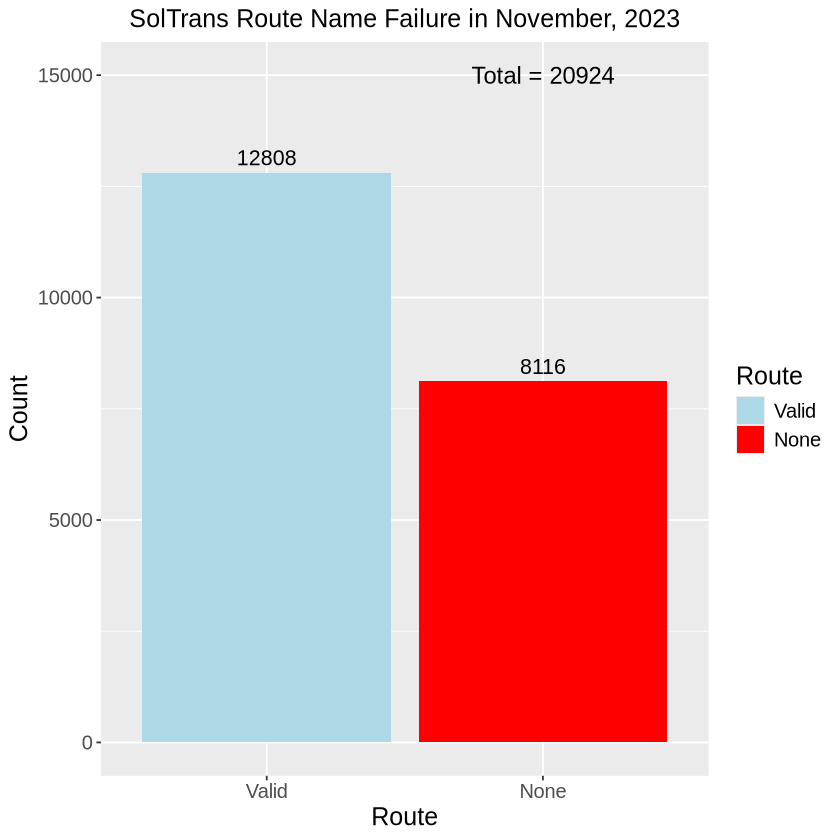

In [19]:
options(repr.plot.width = 7, repr.plot.height =7) 
SolTransNovFare23 %>% 
    mutate(Route = factor(Route, levels = c("Valid", "None"))) %>% 
    ggplot(aes(x = Route, fill = Route)) +
    geom_bar() +
    ggtitle("SolTrans Route Name Failure in November, 2023") +
    ylab("Count") +
    theme(plot.title = element_text(hjust = 0.5, size = 15)) +
    geom_text(
        aes(label=..count..), stat = "count",
        size = 4.5,
        position = position_dodge(0.9),
        vjust = -.5) +
    theme(text = element_text(size = 15),
        axis.text.x = element_text(hjust = 0.5)) +
    scale_fill_manual("Route", values = c("Valid" = "lightblue", "None" = "red")) +
    annotate("text", x=2, y=15000, label= paste0("Total = ", nrow(SolTransNovFare23)), size = 5)


In [20]:
NovFareRevenue23 = SolTransNov23 %>% 
    filter(recordType == 1,
           Bus > 5000) %>% 
    mutate(Route = ifelse(routeId == 835, "None", "Valid")) %>%
    filter(contractId == 0,
           purseAmount != 0,
           transferDiscountFlag == 0) %>% 
    select(Date, Time, Bus, Route, purseAmount)
head(NovFareRevenue23)
dim(NovFareRevenue23)

Date,Time,Bus,Route,purseAmount
<date>,<chr>,<chr>,<chr>,<dbl>
2023-11-01,15:35:00,5110,Valid,500
2023-11-01,16:26:00,5116,None,200
2023-11-01,07:19:00,5105,Valid,500
2023-11-01,08:23:00,5105,Valid,250
2023-11-01,10:27:00,5117,Valid,250
2023-11-01,12:34:00,5117,Valid,500


[1] 14920     5

In [21]:
NovFareRevenue23 %>% 
    filter(Route == "None") %>% 
    dim()

[1] 5993    5

In [22]:
SolTransTU_NovFareRevenue = NovFareRevenue23 %>% 
    # select(-trip_id) %>% 
    # distinct() %>% 
    # mutate(Reason = "Clipper") %>% 
    # right_join(NovFareRevenue) %>% 
    # replace_na(list(Reason = "CNX"))  %>% 
    mutate(
        # RouteID = ifelse(Route == "Valid", Route, paste0("Loss-", Reason)),
        Fare = ifelse(Route == "None", purseAmount * 2.5, purseAmount))
head(SolTransTU_NovFareRevenue)
dim(SolTransTU_NovFareRevenue)

Date,Time,Bus,Route,purseAmount,Fare
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>
2023-11-01,15:35:00,5110,Valid,500,500
2023-11-01,16:26:00,5116,None,200,500
2023-11-01,07:19:00,5105,Valid,500,500
2023-11-01,08:23:00,5105,Valid,250,250
2023-11-01,10:27:00,5117,Valid,250,250
2023-11-01,12:34:00,5117,Valid,500,500


[1] 14920     6

In [23]:
SolTransTU_NovFareRevenue = SolTransTU_NovFareRevenue %>% 
    mutate(Loss = Fare - purseAmount)


In [24]:
head(SolTransTU_NovFareRevenue)

Date,Time,Bus,Route,purseAmount,Fare,Loss
<date>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2023-11-01,15:35:00,5110,Valid,500,500,0
2023-11-01,16:26:00,5116,None,200,500,300
2023-11-01,07:19:00,5105,Valid,500,500,0
2023-11-01,08:23:00,5105,Valid,250,250,0
2023-11-01,10:27:00,5117,Valid,250,250,0
2023-11-01,12:34:00,5117,Valid,500,500,0


In [25]:
X =  SolTransTU_NovFareRevenue %>% 
    group_by(Route) %>% 
    summarise(Total = sum(Loss)/100) %>% 
    filter(Route == "None") %>% 
    add_row(Route = "Revenue", Total  = sum(SolTransNov23$purseAmount, na.rm = TRUE)/100) %>% 
    mutate(Route = ifelse(Route == "None", "Loss", Route))
X

Route,Total
<chr>,<dbl>
Loss,16030.5
Revenue,58741.4


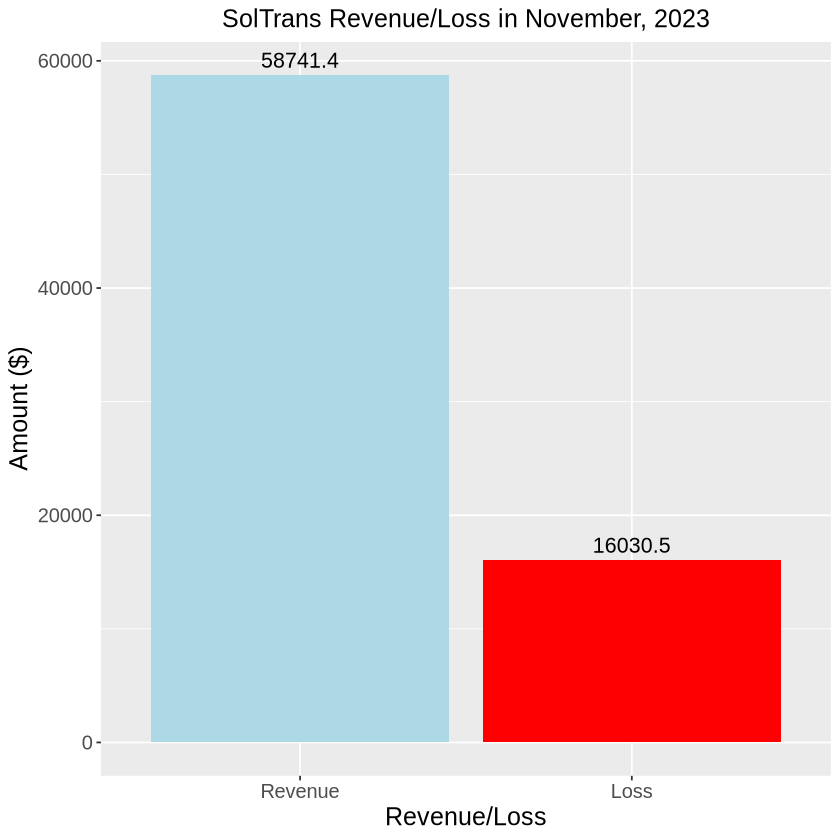

In [26]:
X%>% 
    mutate(Route = factor(Route, levels = c("Revenue", "Loss"))) %>% 
    ggplot(aes(x = Route, y = Total , fill = Route)) +
    geom_bar(stat = "identity") +
    ggtitle("SolTrans Revenue/Loss in November, 2023") +
    ylab("Amount ($)") +
    xlab("Revenue/Loss")+
    theme(plot.title = element_text(hjust = 0.5, size = 15)) +
    theme(legend.position = "none") +
    geom_text(
        aes(label=Total), stat = "identity",
        size = 4.5,
        position = position_dodge(0.9),
        vjust = -.5) +
    theme(text = element_text(size = 15),
        axis.text.x = element_text(hjust = 0.5)) +
    scale_fill_manual("Route", values = c("Revenue" = "lightblue", "Loss" = "red")) 
    # annotate("text", x=2, y=7500, label= paste0("Total Loss = ", sum(X$Fares)), size = 5)


In [27]:
SolTransAnnual = tibble(Month = "Nov23", Revenue = X$Total[2], Loss = X$Total[1])
SolTransAnnual

Month,Revenue,Loss
<chr>,<dbl>,<dbl>
Nov23,58741.4,16030.5


# December 2023 

In [28]:
SolTransDec23 = read_csv("../fs_kit/data/20231200009.000000.csv", col_select = c(
  operatorId,
  deviceSerialNumber,
  routeId,
  PST,
  recordType,
  fareTransactionSubType,
  contractId,
  productCategory,
  purseAmount,
  # purseBalance,
  # fareCategory,
  # transferOperator,
  transferDiscountFlag,
  # fareDiscount,
  # deviceEventTransactionSubType,
  # eventCode1 = eventCode33,
  # eventCode16 = eventCode,
  # # Description,
  # routeId30
  )
)

Rows: 93295 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): PST
dbl (9): operatorId, deviceSerialNumber, routeId, recordType, fareTransactio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [29]:
SolTransDec23 = SolTransDec23 %>% 
    mutate(PST = mdy_hm(PST), 
           Date = as.Date(PST),
           Time = format(PST, format = "%H:%M:%S")) %>% 
     filter(operatorId == 9,
            recordType == 1,
            Date >= "2023-12-01",
            deviceSerialNumber > 7805802,
            deviceSerialNumber < 7805874)
head(SolTransDec23)

operatorId,deviceSerialNumber,routeId,PST,recordType,fareTransactionSubType,contractId,productCategory,purseAmount,transferDiscountFlag,Date,Time
<dbl>,<dbl>,<dbl>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<chr>
9,7805823,835,2023-12-01 06:07:00,1,1,916,4,0,0,2023-12-01,06:07:00
9,7805860,781,2023-12-01 14:27:00,1,1,916,4,0,0,2023-12-01,14:27:00
9,7805853,781,2023-12-01 05:39:00,1,1,0,1,500,0,2023-12-01,05:39:00
9,7805824,781,2023-12-01 18:24:00,1,1,0,1,500,0,2023-12-01,18:24:00
9,7805851,816,2023-12-01 07:13:00,1,1,0,1,500,0,2023-12-01,07:13:00
9,7805816,835,2023-12-01 15:06:00,1,1,0,1,100,0,2023-12-01,15:06:00


In [30]:
dim(SolTransDec23)

[1] 18077    12

In [31]:
SolTransDec23 = SolTransDec23 %>% 
    inner_join(Bus1) 
dim(SolTransDec23)

Joining with `by = join_by(deviceSerialNumber)`


[1] 18072    13

In [32]:
DecFareRevenue23 = SolTransDec23 %>% 
    filter(recordType == 1,
           Bus > 5000) %>% 
    mutate(Route = ifelse(routeId == 835, "None", "Valid")) %>%
    filter(contractId == 0,
           purseAmount != 0,
           transferDiscountFlag == 0) %>% 
    select(Date, Time, Bus, Route, purseAmount)
head(DecFareRevenue23)
dim(DecFareRevenue23)

Date,Time,Bus,Route,purseAmount
<date>,<chr>,<chr>,<chr>,<dbl>
2023-12-01,05:39:00,5054,Valid,500
2023-12-01,18:24:00,5106,Valid,500
2023-12-01,07:13:00,5104,Valid,500
2023-12-01,15:06:00,5059,None,100
2023-12-01,11:13:00,5053,Valid,250
2023-12-01,15:23:00,5101,Valid,250


[1] 12914     5

In [33]:
X = DecFareRevenue23 %>% 
    mutate(
        Fare = ifelse(Route == "None", purseAmount * 2.5, purseAmount),
        Loss = Fare - purseAmount) %>% 
    group_by(Route) %>% 
    summarise(Total = sum(Loss)/100) %>% 
    filter(Route == "None") %>% 
    add_row(Route = "Revenue", Total  = sum(SolTransDec23$purseAmount, na.rm = TRUE)/100) %>% 
    mutate(Route = ifelse(Route == "None", "Loss", Route))

head(X)
dim(X)

Route,Total
<chr>,<dbl>
Loss,12027.6
Revenue,52879.8


[1] 2 2

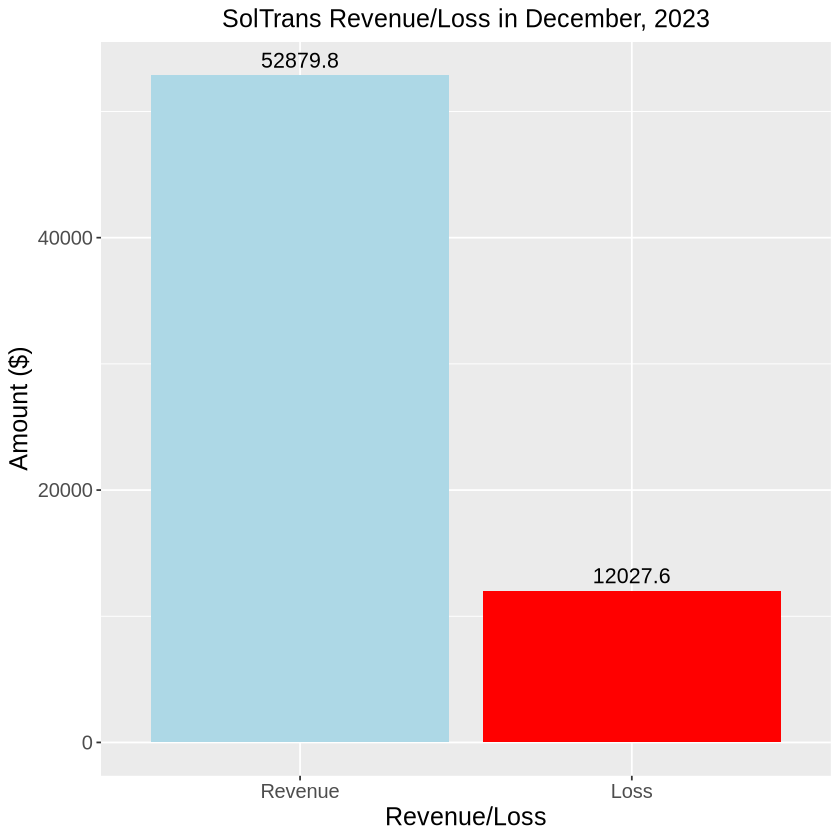

In [34]:
X %>% 
    mutate(Route = factor(Route, levels = c("Revenue", "Loss"))) %>% 
    ggplot(aes(x = Route, y = Total , fill = Route)) +
    geom_bar(stat = "identity") +
    ggtitle("SolTrans Revenue/Loss in December, 2023") +
    ylab("Amount ($)") +
    xlab("Revenue/Loss")+
    theme(plot.title = element_text(hjust = 0.5, size = 15)) +
    theme(legend.position = "none") +
    geom_text(
        aes(label=Total), stat = "identity",
        size = 4.5,
        position = position_dodge(0.9),
        vjust = -.5) +
    theme(text = element_text(size = 15),
        axis.text.x = element_text(hjust = 0.5)) +
    scale_fill_manual("Route", values = c("Revenue" = "lightblue", "Loss" = "red")) 
    # annotate("text", x=2, y=7500, label= paste0("Total Loss = ", sum(X$Fares)), size = 5)


In [35]:
SolTransAnnual = SolTransAnnual %>% 
    add_row(Month = "Dec23", Revenue = X$Total[2], Loss = X$Total[1]) 

SolTransAnnual

Month,Revenue,Loss
<chr>,<dbl>,<dbl>
Nov23,58741.4,16030.5
Dec23,52879.8,12027.6


# January 2024 

In [36]:
SolTransJan24 = read_csv("../fs_kit/data/20240100009.000000.csv", col_select = c(
  operatorId,
  deviceSerialNumber,
  routeId,
  PST,
  recordType,
  contractId,
  purseAmount,
  transferDiscountFlag)) %>% 
     filter(operatorId == 9,
            deviceSerialNumber > 7805802,
            deviceSerialNumber < 7805874)

head(SolTransJan24)
dim(SolTransJan24)

Rows: 103314 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): PST
dbl (7): operatorId, deviceSerialNumber, routeId, recordType, contractId, pu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


operatorId,deviceSerialNumber,routeId,PST,recordType,contractId,purseAmount,transferDiscountFlag
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
9,7805835,415,1/2/2024 16:13,1,0,200,0
9,7805832,835,1/2/2024 16:01,1,0,200,0
9,7805860,817,1/2/2024 5:31,1,0,500,0
9,7805844,420,1/2/2024 16:46,1,0,200,0
9,7805852,835,1/2/2024 8:03,1,0,200,0
9,7805838,418,12/30/2023 16:32,1,0,200,0


[1] 44122     8

In [37]:
X = SolTransJan24 %>% 
    mutate(PST = mdy_hm(PST), 
           Date = as.Date(PST),
           Time = format(PST, format = "%H:%M:%S"),
           Route = ifelse(routeId == 835, "None", "Valid"),
           Fare = ifelse(Route == "None", purseAmount * 2.5, purseAmount),
           Loss = Fare - purseAmount) %>% 
     inner_join(Bus1) %>%  
     filter(operatorId == 9,
            recordType == 1,
            Date >= "2024-01-01",
            deviceSerialNumber > 7805802,
            deviceSerialNumber < 7805874,
            Bus > 5000,
            contractId == 0,
            purseAmount != 0,
            transferDiscountFlag == 0) %>% 
     select(Route, Loss) %>% 
    group_by(Route) %>% 
    summarise(Total = sum(Loss)/100) %>% 
    filter(Route == "None") %>% 
    add_row(Route = "Revenue", Total  = sum(SolTransJan24$purseAmount, na.rm = TRUE)/100) %>% 
    mutate(Route = ifelse(Route == "None", "Loss", Route))


Joining with `by = join_by(deviceSerialNumber)`


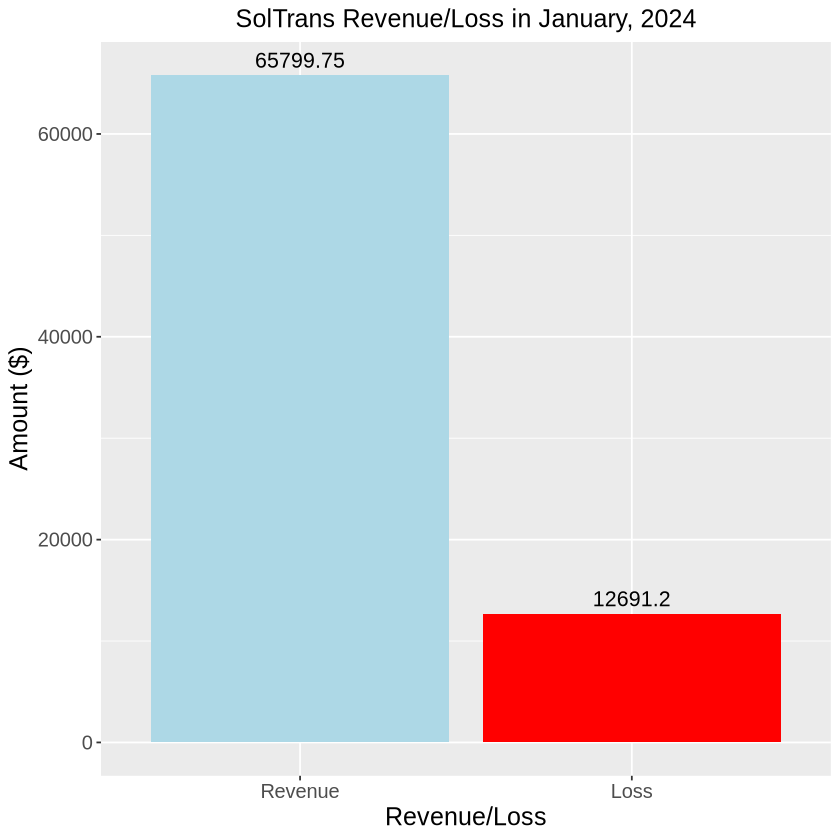

In [38]:
X %>% 
    mutate(Route = factor(Route, levels = c("Revenue", "Loss"))) %>% 
    ggplot(aes(x = Route, y = Total , fill = Route)) +
    geom_bar(stat = "identity") +
    ggtitle("SolTrans Revenue/Loss in January, 2024") +
    ylab("Amount ($)") +
    xlab("Revenue/Loss")+
    theme(plot.title = element_text(hjust = 0.5, size = 15)) +
    theme(legend.position = "none") +
    geom_text(
        aes(label=Total), stat = "identity",
        size = 4.5,
        position = position_dodge(0.9),
        vjust = -.5) +
    theme(text = element_text(size = 15),
        axis.text.x = element_text(hjust = 0.5)) +
    scale_fill_manual("Route", values = c("Revenue" = "lightblue", "Loss" = "red")) 
    # annotate("text", x=2, y=7500, label= paste0("Total Loss = ", sum(X$Fares)), size = 5)


In [39]:
SolTransAnnual = SolTransAnnual %>% 
    add_row(Month = "Jan24", Revenue = X$Total[2], Loss = X$Total[1]) 

SolTransAnnual

Month,Revenue,Loss
<chr>,<dbl>,<dbl>
Nov23,58741.40,16030.5
Dec23,52879.80,12027.6
Jan24,65799.75,12691.2


# February 2024 

In [40]:
SolTransFeb24 = read_csv("../fs_kit/data/20240200009.000000.csv", col_select = c(
  operatorId,
  deviceSerialNumber,
  routeId,
  PST,
  recordType,
  contractId,
  purseAmount,
  transferDiscountFlag,
  )
)%>% 
     filter(operatorId == 9,
            deviceSerialNumber > 7805802,
            deviceSerialNumber < 7805874)

head(SolTransFeb24)
dim(SolTransFeb24)

Rows: 100424 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): PST
dbl (7): operatorId, deviceSerialNumber, routeId, recordType, contractId, pu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


operatorId,deviceSerialNumber,routeId,PST,recordType,contractId,purseAmount,transferDiscountFlag
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
9,7805851,781,2/1/2024 6:09,1,916,0,0
9,7805832,781,2/1/2024 16:46,1,916,0,0
9,7805832,781,1/31/2024 16:43,1,916,0,0
9,7805853,835,2/1/2024 8:01,1,0,200,0
9,7805823,816,2/1/2024 7:12,1,0,500,0
9,7805837,781,2/1/2024 15:22,1,0,500,0


[1] 42770     8

In [41]:
X = SolTransFeb24 %>% 
    mutate(PST = mdy_hm(PST), 
           Date = as.Date(PST),
           Time = format(PST, format = "%H:%M:%S"),
           Route = ifelse(routeId == 835, "None", "Valid"),
           Fare = ifelse(Route == "None", purseAmount * 2.5, purseAmount),
           Loss = Fare - purseAmount) %>% 
     inner_join(Bus1) %>%  
     filter(operatorId == 9,
            recordType == 1,
            Date >= "2024-02-01",
            deviceSerialNumber > 7805802,
            deviceSerialNumber < 7805874,
            Bus > 5000,
            contractId == 0,
            purseAmount != 0,
            transferDiscountFlag == 0) %>% 
     select(Route, Loss) %>% 
    group_by(Route) %>% 
    summarise(Total = sum(Loss)/100) %>% 
    filter(Route == "None") %>% 
    add_row(Route = "Revenue", Total  = sum(SolTransFeb24$purseAmount, na.rm = TRUE)/100) %>% 
    mutate(Route = ifelse(Route == "None", "Loss", Route)) 


Joining with `by = join_by(deviceSerialNumber)`


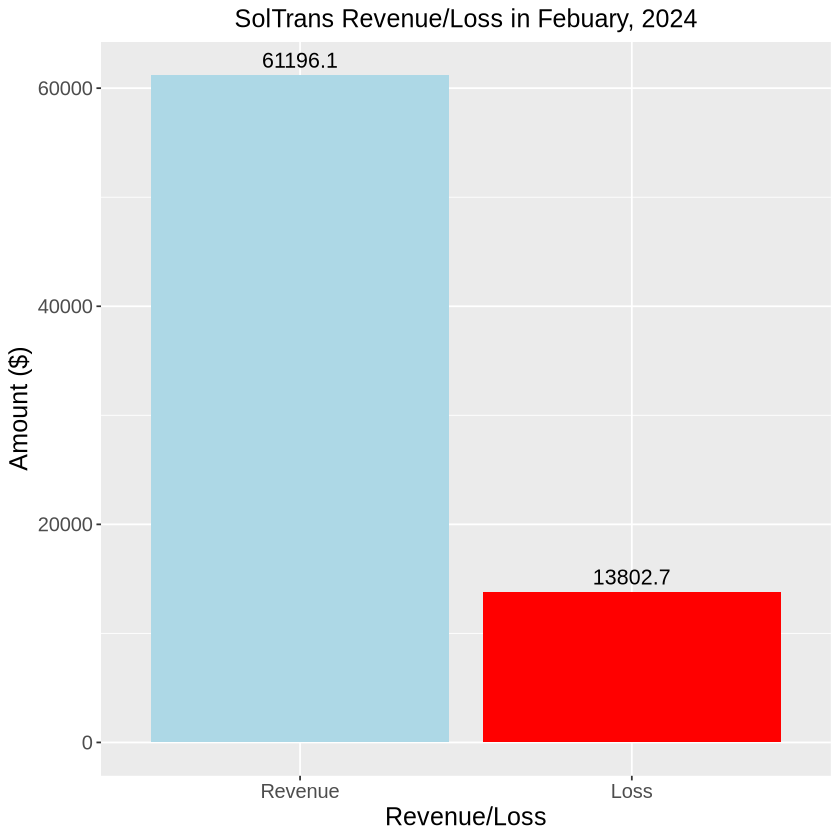

In [42]:
X %>% 
    mutate(Route = factor(Route, levels = c("Revenue", "Loss"))) %>% 
    ggplot(aes(x = Route, y = Total , fill = Route)) +
    geom_bar(stat = "identity") +
    ggtitle("SolTrans Revenue/Loss in Febuary, 2024") +
    ylab("Amount ($)") +
    xlab("Revenue/Loss")+
    theme(plot.title = element_text(hjust = 0.5, size = 15)) +
    theme(legend.position = "none") +
    geom_text(
        aes(label=Total), stat = "identity",
        size = 4.5,
        position = position_dodge(0.9),
        vjust = -.5) +
    theme(text = element_text(size = 15),
        axis.text.x = element_text(hjust = 0.5)) +
    scale_fill_manual("Route", values = c("Revenue" = "lightblue", "Loss" = "red")) 
    # annotate("text", x=2, y=7500, label= paste0("Total Loss = ", sum(X$Fares)), size = 5)


In [43]:
SolTransAnnual = SolTransAnnual %>% 
    add_row(Month = "Feb24", Revenue = X$Total[2], Loss = X$Total[1]) 

SolTransAnnual

Month,Revenue,Loss
<chr>,<dbl>,<dbl>
Nov23,58741.40,16030.5
Dec23,52879.80,12027.6
Jan24,65799.75,12691.2
Feb24,61196.10,13802.7


# November 2024 

In [44]:
SolTransNov24 = read_csv("../fs_kit/data/20241100009.000000.csv", col_select = c(
  operatorId,
  deviceSerialNumber,
  routeId,
  PST,
  recordType,
  contractId,
  purseAmount,
  transferDiscountFlag,
  )
)%>% 
     filter(operatorId == 9,
            deviceSerialNumber > 7805802,
            deviceSerialNumber < 7805874)

head(SolTransNov24)
dim(SolTransNov24)

Rows: 90821 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): PST
dbl (7): operatorId, deviceSerialNumber, routeId, recordType, contractId, pu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


operatorId,deviceSerialNumber,routeId,PST,recordType,contractId,purseAmount,transferDiscountFlag
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
9,7805858,835,10/26/2024 12:19,6,NA,NA,NA
9,7805858,835,10/26/2024 12:19,6,NA,NA,NA
9,7805858,835,10/26/2024 12:19,6,NA,NA,NA
9,7805859,835,10/28/2024 11:09,6,NA,NA,NA
9,7805859,835,10/28/2024 11:09,6,NA,NA,NA
9,7805859,835,10/28/2024 11:09,6,NA,NA,NA


[1] 43992     8

In [45]:
X = SolTransNov24 %>% 
    mutate(PST = mdy_hm(PST), 
           Date = as.Date(PST),
           Time = format(PST, format = "%H:%M:%S"),
           Route = ifelse(routeId == 835, "None", "Valid"),
           Fare = ifelse(Route == "None", purseAmount * 2.5, purseAmount),
           Loss = Fare - purseAmount) %>% 
     inner_join(Bus1) %>%  
     filter(operatorId == 9,
            recordType == 1,
            Date >= "2024-11-01",
            deviceSerialNumber > 7805802,
            deviceSerialNumber < 7805874,
            Bus > 5000,
            contractId == 0,
            purseAmount != 0,
            transferDiscountFlag == 0) %>% 
     select(Route, Loss)%>% 
    group_by(Route) %>% 
    summarise(Total = sum(Loss)/100) %>% 
    filter(Route == "None") %>% 
    add_row(Route = "Revenue", Total  = sum(SolTransNov24$purseAmount, na.rm = TRUE)/100) %>% 
    mutate(Route = ifelse(Route == "None", "Loss", Route))

Joining with `by = join_by(deviceSerialNumber)`


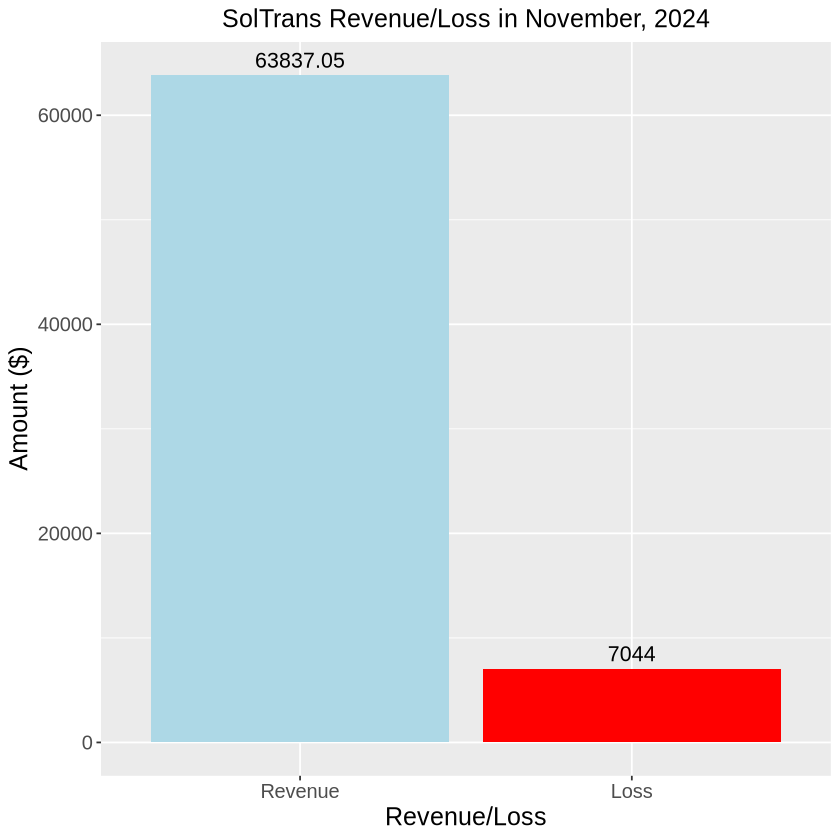

In [46]:
X %>% 
    mutate(Route = factor(Route, levels = c("Revenue", "Loss"))) %>% 
    ggplot(aes(x = Route, y = Total , fill = Route)) +
    geom_bar(stat = "identity") +
    ggtitle("SolTrans Revenue/Loss in November, 2024") +
    ylab("Amount ($)") +
    xlab("Revenue/Loss")+
    theme(plot.title = element_text(hjust = 0.5, size = 15)) +
    theme(legend.position = "none") +
    geom_text(
        aes(label=Total), stat = "identity",
        size = 4.5,
        position = position_dodge(0.9),
        vjust = -.5) +
    theme(text = element_text(size = 15),
        axis.text.x = element_text(hjust = 0.5)) +
    scale_fill_manual("Route", values = c("Revenue" = "lightblue", "Loss" = "red")) 
    # annotate("text", x=2, y=7500, label= paste0("Total Loss = ", sum(X$Fares)), size = 5)


In [47]:
SolTransAnnual = SolTransAnnual %>% 
    add_row(Month = "Nov24", Revenue = X$Total[2], Loss = X$Total[1]) 

SolTransAnnual

Month,Revenue,Loss
<chr>,<dbl>,<dbl>
Nov23,58741.40,16030.5
Dec23,52879.80,12027.6
Jan24,65799.75,12691.2
Feb24,61196.10,13802.7
Nov24,63837.05,7044.0


# December 2024 

In [48]:
SolTransDec24 = read_csv("../fs_kit/data/20241200009.000000.csv", col_select = c(
  operatorId,
  deviceSerialNumber,
  routeId,
  PST,
  recordType,
  contractId,
  purseAmount,
  transferDiscountFlag,
  )
)%>% 
     filter(operatorId == 9,
            deviceSerialNumber > 7805802,
            deviceSerialNumber < 7805874)

head(SolTransDec24)
dim(SolTransDec24)

Rows: 88542 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): PST
dbl (7): operatorId, deviceSerialNumber, routeId, recordType, contractId, pu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


operatorId,deviceSerialNumber,routeId,PST,recordType,contractId,purseAmount,transferDiscountFlag
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
9,7805846,835,11/30/2024 9:02,1,0,200,0
9,7805846,781,12/1/2024 9:03,1,0,500,0
9,7805846,781,12/1/2024 11:43,1,0,500,0
9,7805818,781,11/30/2024 10:24,1,0,250,0
9,7805846,781,12/1/2024 10:14,1,0,250,0
9,7805846,781,12/1/2024 14:08,1,0,500,0


[1] 41979     8

In [49]:
X = SolTransDec24 %>% 
    mutate(PST = mdy_hm(PST), 
           Date = as.Date(PST),
           Time = format(PST, format = "%H:%M:%S"),
           Route = ifelse(routeId == 835, "None", "Valid"),
           Fare = ifelse(Route == "None", purseAmount * 2.5, purseAmount),
           Loss = Fare - purseAmount) %>% 
     inner_join(Bus1) %>%  
     filter(operatorId == 9,
            recordType == 1,
            Date >= "2024-12-01",
            deviceSerialNumber > 7805802,
            deviceSerialNumber < 7805874,
            Bus > 5000,
            contractId == 0,
            purseAmount != 0,
            transferDiscountFlag == 0) %>% 
     select(Route, Loss)%>% 
    group_by(Route) %>% 
    summarise(Total = sum(Loss)/100) %>% 
    filter(Route == "None") %>% 
    add_row(Route = "Revenue", Total  = sum(SolTransDec24$purseAmount, na.rm = TRUE)/100) %>% 
    mutate(Route = ifelse(Route == "None", "Loss", Route))

Joining with `by = join_by(deviceSerialNumber)`


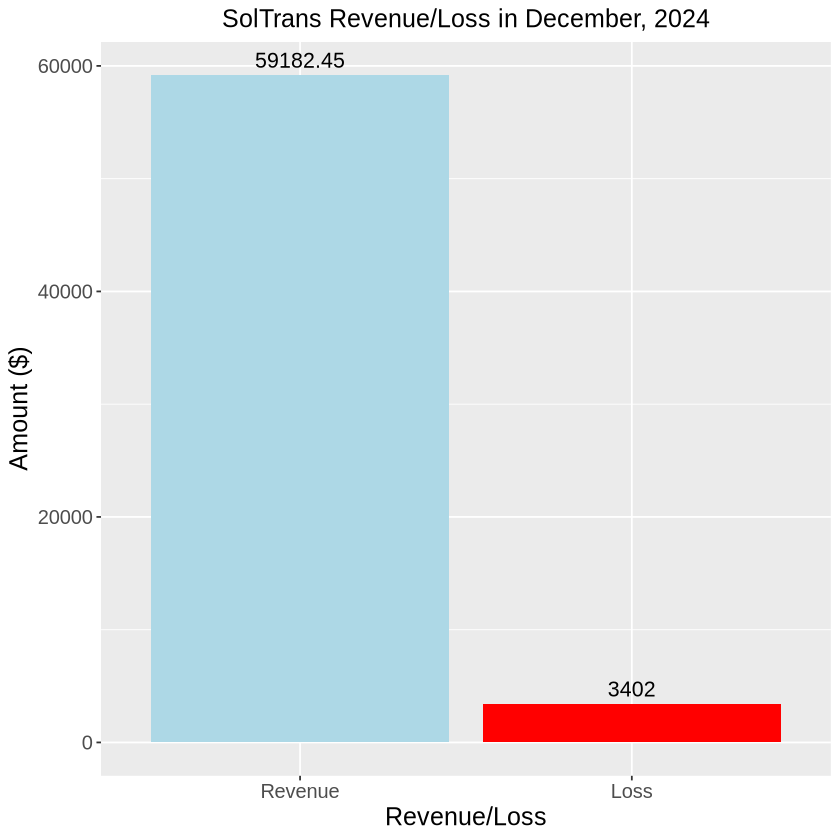

In [50]:
X %>% 
    mutate(Route = factor(Route, levels = c("Revenue", "Loss"))) %>% 
    ggplot(aes(x = Route, y = Total , fill = Route)) +
    geom_bar(stat = "identity") +
    ggtitle("SolTrans Revenue/Loss in December, 2024") +
    ylab("Amount ($)") +
    xlab("Revenue/Loss")+
    theme(plot.title = element_text(hjust = 0.5, size = 15)) +
    theme(legend.position = "none") +
    geom_text(
        aes(label=Total), stat = "identity",
        size = 4.5,
        position = position_dodge(0.9),
        vjust = -.5) +
    theme(text = element_text(size = 15),
        axis.text.x = element_text(hjust = 0.5)) +
    scale_fill_manual("Route", values = c("Revenue" = "lightblue", "Loss" = "red")) 
    # annotate("text", x=2, y=7500, label= paste0("Total Loss = ", sum(X$Fares)), size = 5)


In [51]:
SolTransAnnual = SolTransAnnual %>% 
    add_row(Month = "Dec24", Revenue = X$Total[2], Loss = X$Total[1]) 

SolTransAnnual

Month,Revenue,Loss
<chr>,<dbl>,<dbl>
Nov23,58741.40,16030.5
Dec23,52879.80,12027.6
Jan24,65799.75,12691.2
Feb24,61196.10,13802.7
Nov24,63837.05,7044.0
Dec24,59182.45,3402.0


# January 2025

In [52]:
SolTransJan25 = read_csv("../fs_kit/data/20250100009.000000.csv", col_select = c(
  operatorId,
  deviceSerialNumber,
  routeId,
  PST,
  recordType,
  contractId,
  purseAmount,
  transferDiscountFlag,
  )
)%>% 
     filter(operatorId == 9,
            deviceSerialNumber > 7805802,
            deviceSerialNumber < 7805874)

head(SolTransJan25)
dim(SolTransJan25)

Rows: 110021 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): PST
dbl (7): operatorId, deviceSerialNumber, routeId, recordType, contractId, pu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


operatorId,deviceSerialNumber,routeId,PST,recordType,contractId,purseAmount,transferDiscountFlag
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
9,7805824,741,1/2/2025 4:33,1,0,600,0
9,7805837,817,1/2/2025 10:20,1,0,500,0
9,7805824,781,1/2/2025 7:43,1,0,500,0
9,7805837,781,1/2/2025 20:48,1,0,500,0
9,7805873,817,1/2/2025 4:12,1,916,0,0
9,7805845,657,1/2/2025 15:37,1,0,0,1


[1] 41560     8

In [53]:
X = SolTransJan25 %>% 
    mutate(PST = mdy_hm(PST), 
           Date = as.Date(PST),
           Time = format(PST, format = "%H:%M:%S"),
           Route = ifelse(routeId == 835, "None", "Valid"),
           Fare = ifelse(Route == "None", purseAmount * 2.5, purseAmount),
           Loss = Fare - purseAmount) %>% 
     inner_join(Bus1) %>%  
     filter(operatorId == 9,
            recordType == 1,
            Date >= "2025-01-01",
            deviceSerialNumber > 7805802,
            deviceSerialNumber < 7805874,
            Bus > 5000,
            contractId == 0,
            purseAmount != 0,
            transferDiscountFlag == 0) %>% 
     select(Route, Loss)%>% 
     group_by(Route) %>% 
     summarise(Total = sum(Loss)/100) %>% 
     filter(Route == "None") %>% 
     add_row(Route = "Revenue", Total  = sum(SolTransJan25$purseAmount, na.rm = TRUE)/100) %>% 
     mutate(Route = ifelse(Route == "None", "Loss", Route))

Joining with `by = join_by(deviceSerialNumber)`


In [54]:
X

Route,Total
<chr>,<dbl>
Loss,2196.0
Revenue,55385.8


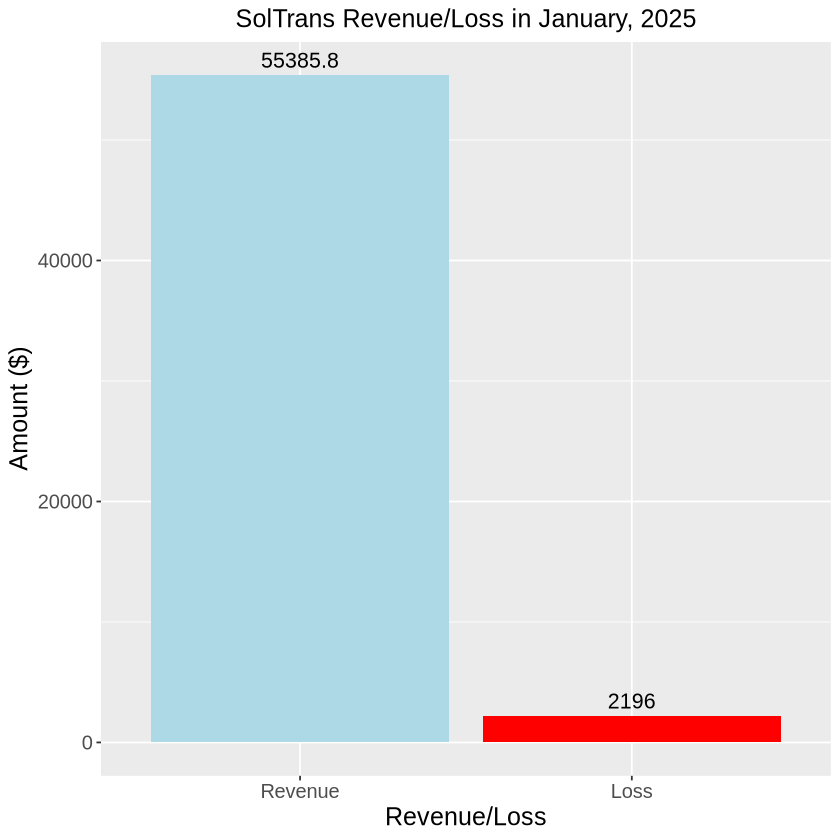

In [55]:
X %>% 
    mutate(Route = factor(Route, levels = c("Revenue", "Loss"))) %>% 
    ggplot(aes(x = Route, y = Total , fill = Route)) +
    geom_bar(stat = "identity") +
    ggtitle("SolTrans Revenue/Loss in January, 2025") +
    ylab("Amount ($)") +
    xlab("Revenue/Loss")+
    theme(plot.title = element_text(hjust = 0.5, size = 15)) +
    theme(legend.position = "none") +
    geom_text(
        aes(label=Total), stat = "identity",
        size = 4.5,
        position = position_dodge(0.9),
        vjust = -.5) +
    theme(text = element_text(size = 15),
        axis.text.x = element_text(hjust = 0.5)) +
    scale_fill_manual("Route", values = c("Revenue" = "lightblue", "Loss" = "red")) 
    # annotate("text", x=2, y=7500, label= paste0("Total Loss = ", sum(X$Fares)), size = 5)


In [56]:
SolTransAnnual = SolTransAnnual %>% 
    add_row(Month = "Jan25", Revenue = X$Total[2], Loss = X$Total[1]) 

SolTransAnnual

Month,Revenue,Loss
<chr>,<dbl>,<dbl>
Nov23,58741.40,16030.5
Dec23,52879.80,12027.6
Jan24,65799.75,12691.2
Feb24,61196.10,13802.7
Nov24,63837.05,7044.0
Dec24,59182.45,3402.0
Jan25,55385.80,2196.0


In [57]:
library(reshape2)

In [58]:
melt(SolTransAnnual)

Using Month as id variables



Month,variable,value
<chr>,<fct>,<dbl>
Nov23,Revenue,58741.40
Dec23,Revenue,52879.80
Jan24,Revenue,65799.75
Feb24,Revenue,61196.10
Nov24,Revenue,63837.05
Dec24,Revenue,59182.45
Jan25,Revenue,55385.80
Nov23,Loss,16030.50
Dec23,Loss,12027.60


Using Month as id variables



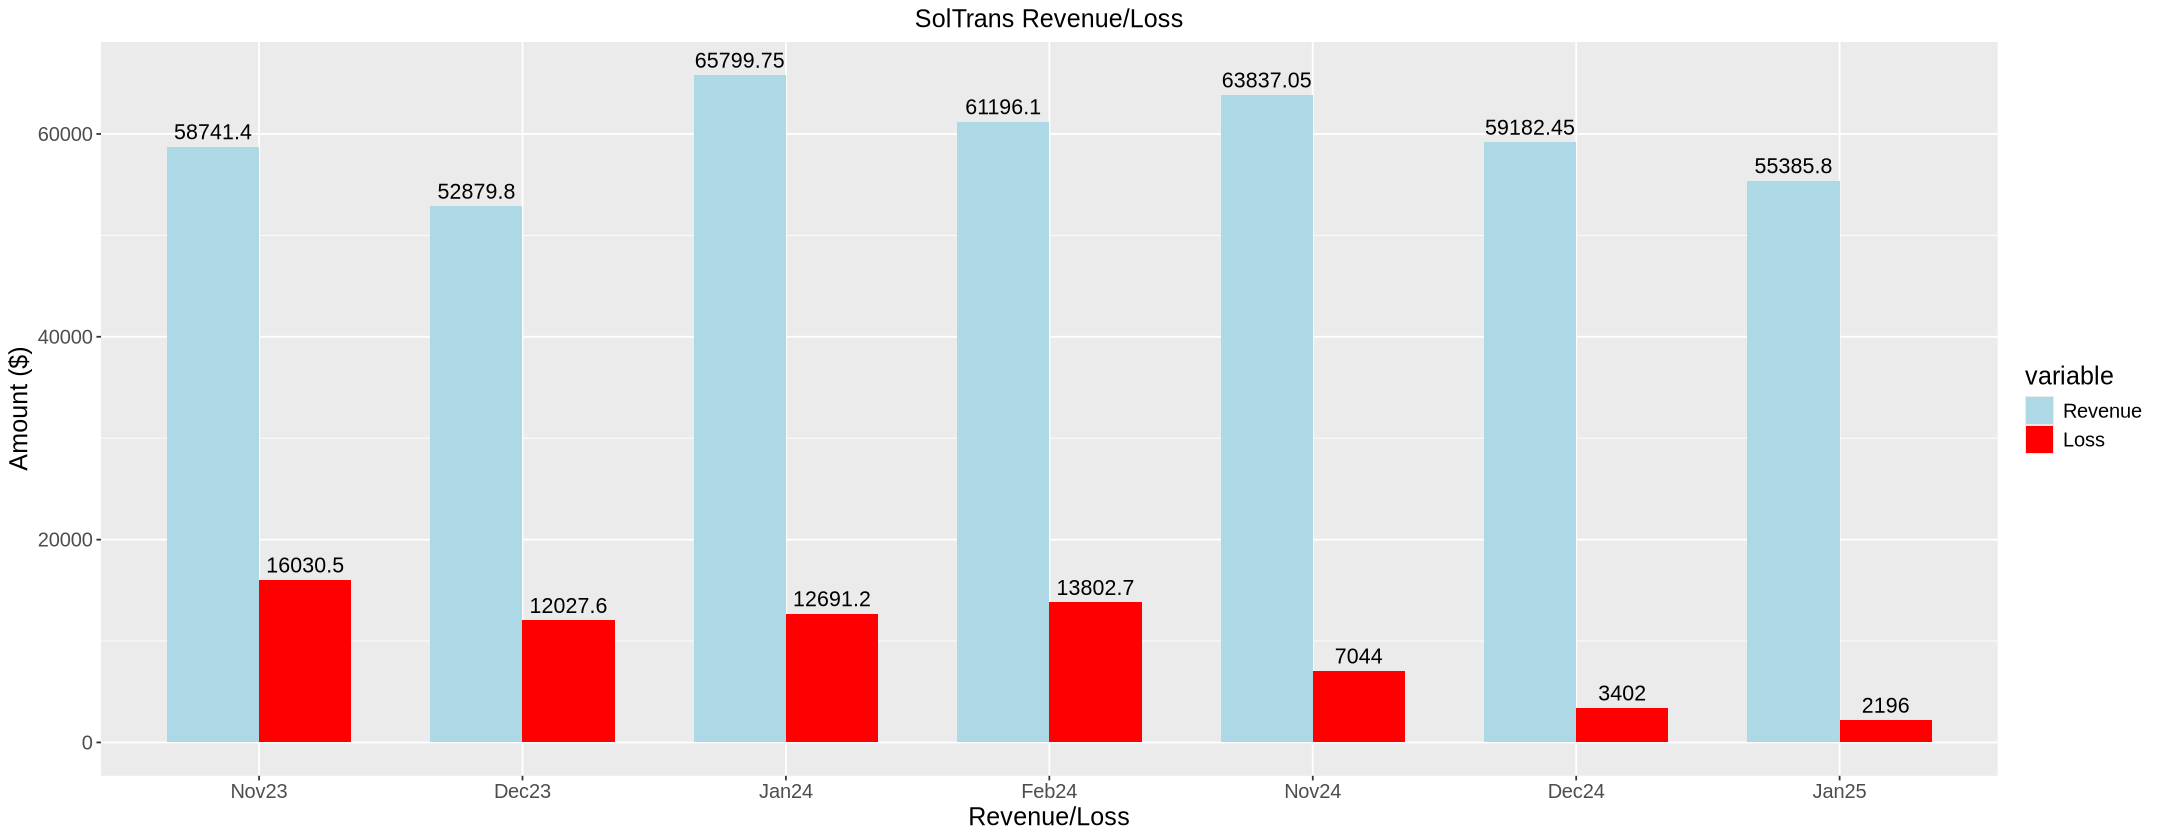

In [59]:
options(repr.plot.width = 18, repr.plot.height =7) 
SolTransAnnual %>%
    mutate(Month = factor(Month, levels = c("Nov23", "Dec23", "Jan24", "Feb24", "Nov24", "Dec24", "Jan25"))) %>% 
    melt() %>% 
    # mutate(Route = factor(Route, levels = c("Revenue", "Loss"))) %>% 
    ggplot(aes(x = Month, y = value , fill = variable)) +
    geom_bar (stat="identity", position ="dodge", width = .7) +
    ggtitle("SolTrans Revenue/Loss") +
    ylab("Amount ($)") +
    xlab("Revenue/Loss")+
    theme(plot.title = element_text(hjust = 0.5, size = 15)) +
    # theme(legend.position = "none") +
    geom_text(
        aes(label=value), stat = "identity",
        size = 4.5,
        position = position_dodge(0.7),
        vjust = -.5) +
    theme(text = element_text(size = 15),
        axis.text.x = element_text(hjust = 0.5)) +
    scale_fill_manual("variable", values = c("Revenue" = "lightblue", "Loss" = "red")) 

## PreCovid calculation

In [93]:
SolTransAnnual2 <- data.frame(
  Month = rep(NA_character_, 10),
  Revenue = rep(NA_integer_, 10),
  Loss = rep(NA_integer_, 10),
  dayCount = rep(NA_integer_, 10)
)
SolTransAnnual2

Month,Revenue,Loss,dayCount
<chr>,<int>,<int>,<int>
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA
NA,NA,NA,NA


In [95]:
SolTransAnnual3 <- data.frame(
  Month = rep(NA_character_, 10),
  Revenue = rep(NA_integer_, 10),
  Loss = rep(NA_integer_, 10),
  dayCount = rep(NA_integer_, 10),
  Valid = rep(NA_integer_, 10),
  None = rep(NA_integer_, 10)
)
SolTransAnnual3

Month,Revenue,Loss,dayCount,Valid,None
<chr>,<int>,<int>,<int>,<int>,<int>
NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA
NA,NA,NA,NA,NA,NA


In [61]:
Bus2 =  read_csv("../fs_kit/data/Bus2.csv") %>% 
    mutate(Bus = as.character(Bus),
           INSTALLDATE = as.Date(INSTALLDATE, format = "%m/%d/%Y %H:%M"),
           DEINSTALLDATE = as.Date(DEINSTALLDATE, format = "%m/%d/%Y %H:%M")) %>% 
# The following line is for making sure the we have a unique devieSerialNumber field
# as it was repeated over different dates, So I just used the last record fro vevery 
# deviceSerialNumber.
    slice_max(by = deviceSerialNumber, order_by = INSTALLDATE) %>% 
    select(deviceSerialNumber, Bus)
head(Bus2)

Rows: 335 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (8): MODELID, Bus, PLACEID, LOCATIONNAME, SUBLOCATION, INSTALLDATE, DEIN...
dbl (1): deviceSerialNumber

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


deviceSerialNumber,Bus
<dbl>,<chr>
6361101,5112
6361142,5012
6361157,5026
6361161,5112
6361174,3915
6361337,4503


In [62]:
dim(Bus2)

[1] 279   2

In [63]:
analyzedMonths = read_csv("../fs_kit/data/analyzedMonths.csv") %>% 
    mutate(Month = as.character(Month))
analyzedMonths

Rows: 10 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): Month, Bus
dbl (2): month, dayCount

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Month,month,Bus,dayCount
<chr>,<dbl>,<chr>,<dbl>
Dec19,201912,Bus2,31
Jan20,202001,Bus2,31
Feb20,202002,Bus2,29
Nov23,202311,Bus1,30
Dec23,202312,Bus1,31
Jan24,202401,Bus1,31
Feb24,202402,Bus1,29
Nov24,202411,Bus1,30
Dec24,202412,Bus1,31


# December 2019

In [64]:
Month = analyzedMonths$Month[1]
month = analyzedMonths$month[1]
Bus = get(analyzedMonths$Bus[1])

In [65]:
SolTransMonth = read_csv(paste0("../fs_kit/data/", month, "00009.000000.csv"), col_select = c(
  operatorId,
  deviceSerialNumber,
  routeId,
  PST,
  recordType,
  contractId,
  purseAmount,
  transferDiscountFlag,
  )
)%>% 
     filter(operatorId == 9,
            recordType == 1,
            # deviceSerialNumber > 7805802,
            # deviceSerialNumber < 7805874
           ) %>% 
     inner_join(Bus)


head(SolTransMonth)
dim(SolTransMonth)

Rows: 303590 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): PST
dbl (7): operatorId, deviceSerialNumber, routeId, recordType, contractId, pu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(deviceSerialNumber)`


operatorId,deviceSerialNumber,routeId,PST,recordType,contractId,purseAmount,transferDiscountFlag,Bus
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
9,6367129,426,12/1/2019 9:30,1,0,500,0,5111
9,6367129,426,12/1/2019 8:32,1,0,500,0,5111
9,6367129,426,12/1/2019 10:53,1,0,500,0,5111
9,6370185,740,12/1/2019 10:00,1,0,500,0,5110
9,6370185,740,12/1/2019 13:45,1,0,500,0,5110
9,6366547,426,12/1/2019 9:00,1,916,0,0,5116


[1] 36209     9

In [66]:
totalLoss = SolTransMonth %>% 
    filter(routeId == 835, 
           Bus > 5000,
           contractId == 0,
           purseAmount != 0,
           transferDiscountFlag == 0) %>% 
    mutate(Loss = 1.5 * purseAmount) %>% 
    summarise(Total = sum(Loss)/100) %>%
    mutate(Category = "Loss")

In [67]:
revenueLoss = totalLoss %>%
    add_row(Category = "Revenue", Total  = sum(SolTransMonth$purseAmount, na.rm = TRUE)/100)
revenueLoss

Total,Category
<dbl>,<chr>
0.0,Loss
116478.7,Revenue


In [68]:
# revenueLoss %>% 
#     mutate(Category = factor(Category, levels = c("Revenue", "Loss"))) %>% 
#     ggplot(aes(x = Category, y = Total , fill = Category)) +
#     geom_bar(stat = "identity") +
#     ggtitle("SolTrans Revenue/Loss in December, 2019") +
#     ylab("Amount ($)") +
#     xlab("Revenue/Loss")+
#     theme(plot.title = element_text(hjust = 0.5, size = 15)) +
#     theme(legend.position = "none") +
#     geom_text(
#         aes(label=Total), stat = "identity",
#         size = 4.5,
#         position = position_dodge(0.9),
#         vjust = -.5) +
#     theme(text = element_text(size = 15),
#         axis.text.x = element_text(hjust = 0.5)) +
#     scale_fill_manual("Category", values = c("Revenue" = "blue", "Loss" = "red")) 
#     # annotate("text", x=2, y=7500, label= paste0("Total Loss = ", sum(X$Fares)), size = 5)


In [70]:
# SolTransAnnual1 = SolTransAnnual1 %>% 
#     add_row(Month = Month, Revenue = revenueLoss$Total[2], Loss = revenueLoss$Total[1]) 

# SolTransAnnual1

In [96]:
for(i in seq_len(nrow(analyzedMonths))){
    Month = analyzedMonths$Month[i]
    month = analyzedMonths$month[i]
    Bus = get(analyzedMonths$Bus[i])
    dayCount = analyzedMonths$dayCount[i]

    SolTransMonth = read_csv(paste0("../fs_kit/data/", month, "00009.000000.csv"), col_select = c(
      operatorId,
      deviceSerialNumber,
      routeId,
      PST,
      recordType,
      contractId,
      purseAmount,
      transferDiscountFlag,
      ), show_col_types = FALSE
    )%>% 
         filter(operatorId == 9,
                recordType == 1,
               ) %>% 
         inner_join(Bus)

    totalLoss = SolTransMonth %>% 
        filter(routeId == 835, 
               Bus > 5000,
               contractId == 0,
               purseAmount != 0,
               transferDiscountFlag == 0) %>% 
        mutate(Loss = 1.5 * purseAmount) %>% 
        summarise(Total = round(sum(Loss)/100)) %>%
        mutate(Category = "Loss")

    revenueLoss = totalLoss %>%
        add_row(Category = "Revenue", Total  = round(sum(SolTransMonth$purseAmount, na.rm = TRUE)/100))
    SolTransAnnual2[i,] = list(Month = Month, Revenue = revenueLoss$Total[2], Loss = revenueLoss$Total[1], dayCount= dayCount) 
    }
SolTransAnnual2
# SolTransAnnual2 = SolTransAnnual2 %>% 
#     pivot_longer(!Month, names_to = "Category", values_to = "Amount")

Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`


Month,Revenue,Loss,dayCount
<chr>,<dbl>,<dbl>,<dbl>
Dec19,116479,0,31
Jan20,128225,0,31
Feb20,129572,0,29
Nov23,59568,16148,30
Dec23,53312,12230,31
Jan24,65792,12691,31
Feb24,61183,13803,29
Nov24,63837,7264,30
Dec24,59182,3478,31


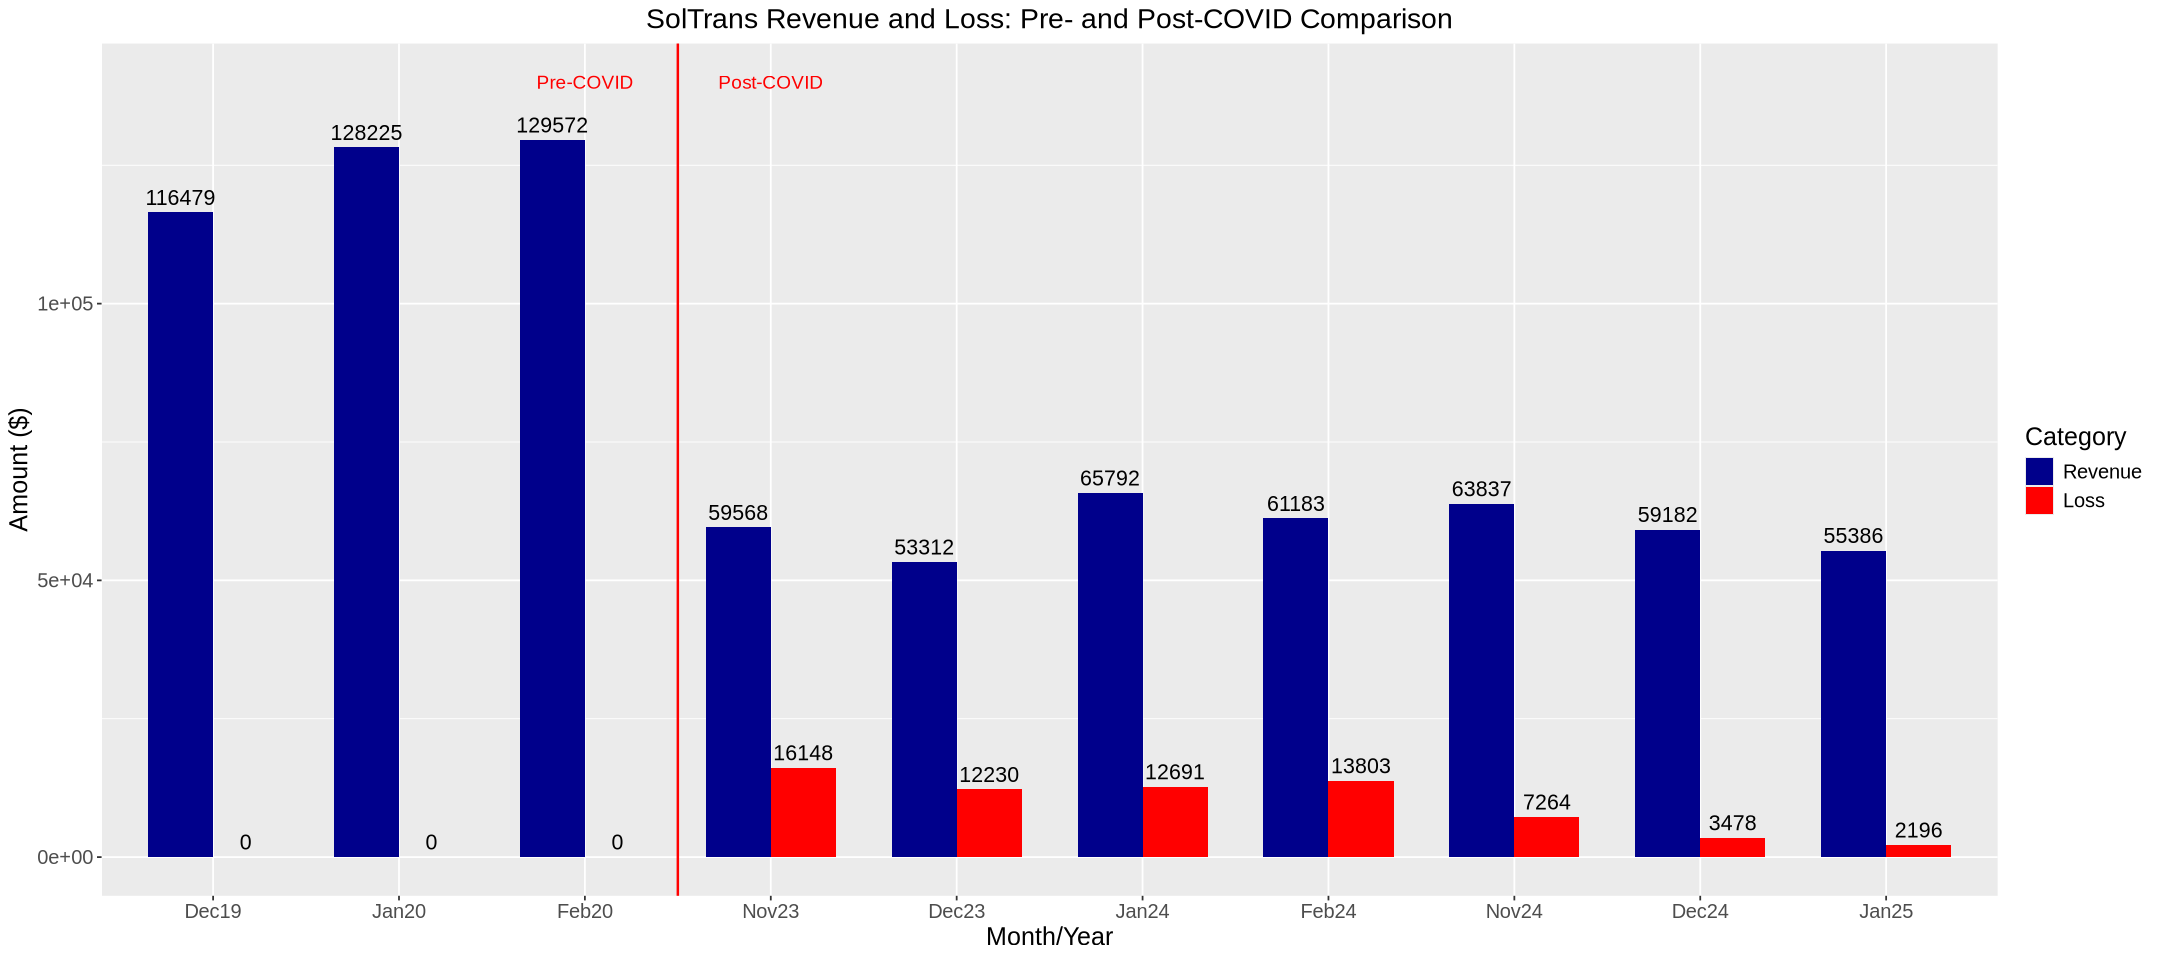

In [97]:
options(repr.plot.width = 18, repr.plot.height =8) 
SolTransAnnual2 %>% 
    select(-dayCount) %>% 
    mutate(Month = factor(Month, levels = pull(SolTransAnnual2, Month))) %>% 
    pivot_longer(!Month, names_to = "Category", values_to = "Amount") %>% 
    mutate(Category = factor(Category, levels = c("Revenue", "Loss"))) %>% 
    ggplot(aes(x = Month, y = Amount , fill = Category)) +
    geom_bar (stat="identity", position ="dodge", width = .7) +
    ggtitle("SolTrans Revenue and Loss: Pre- and Post-COVID Comparison") +
    ylab("Amount ($)") +
    xlab("Month/Year")+
    theme(plot.title = element_text(hjust = 0.5, size = 17)) +
    # theme(legend.position = "none") +
    geom_text(
        aes(label=Amount), stat = "identity",
        size = 4.5,
        position = position_dodge(0.7),
        vjust = -.5) +
    theme(text = element_text(size = 15),
        axis.text.x = element_text(hjust = 0.5)) +
    scale_fill_manual("Category", values = c("Revenue" = "darkblue", "Loss" = "red")) +
    geom_vline(xintercept = 3.5, color = "red", linewidth = .7) +
    annotate("text", x=3, y=140000, label= paste0("Pre-COVID"), size = 4, color = "red") +
    annotate("text", x=4, y=140000, label= paste0("Post-COVID"), size = 4, color = "red")


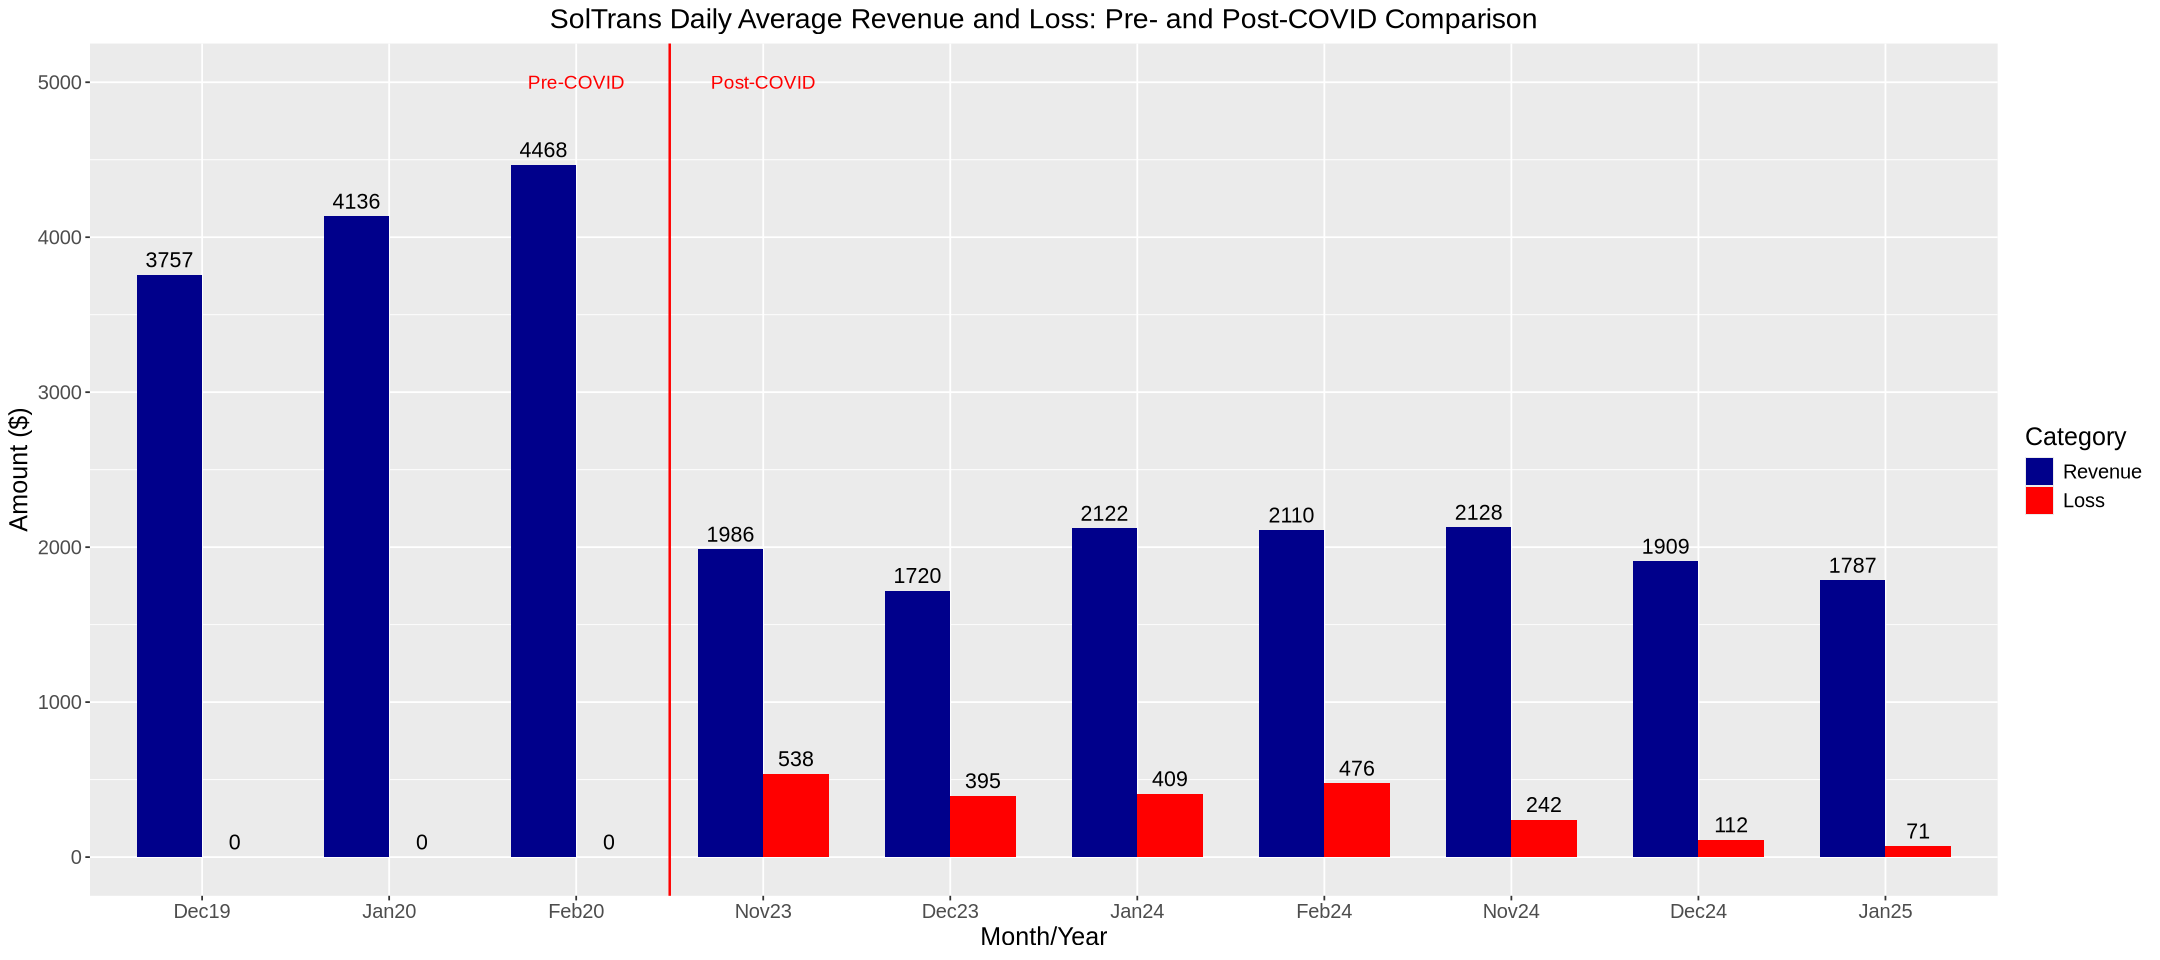

In [73]:
options(repr.plot.width = 18, repr.plot.height =8) 
SolTransAnnual2 %>% 
    mutate(Revenue = round(Revenue/dayCount), Loss = round(Loss/dayCount)) %>% 
    select(-dayCount) %>% 
    mutate(Month = factor(Month, levels = pull(SolTransAnnual2, Month))) %>% 
    pivot_longer(!Month, names_to = "Category", values_to = "Amount") %>% 
    mutate(Category = factor(Category, levels = c("Revenue", "Loss"))) %>% 
    ggplot(aes(x = Month, y = Amount , fill = Category)) +
    geom_bar (stat="identity", position ="dodge", width = .7) +
    ggtitle("SolTrans Daily Average Revenue and Loss: Pre- and Post-COVID Comparison") +
    ylab("Amount ($)") +
    xlab("Month/Year")+
    theme(plot.title = element_text(hjust = 0.5, size = 17)) +
    # theme(legend.position = "none") +
    geom_text(
        aes(label=Amount), stat = "identity",
        size = 4.5,
        position = position_dodge(0.7),
        vjust = -.5) +
    theme(text = element_text(size = 15),
        axis.text.x = element_text(hjust = 0.5)) +
    scale_fill_manual("Category", values = c("Revenue" = "dark blue", "Loss" = "red")) +
    geom_vline(xintercept = 3.5, color = "red", linewidth = .7) +
    annotate("text", x=3, y=5000, label= paste0("Pre-COVID"), size = 4, color = "red") +
    annotate("text", x=4, y=5000, label= paste0("Post-COVID"), size = 4, color = "red")


In [77]:
revenueLoss

Total,Category
<dbl>,<chr>
2196,Loss
55386,Revenue


In [123]:
for(i in seq_len(nrow(analyzedMonths))){
    Month = analyzedMonths$Month[i]
    month = analyzedMonths$month[i]
    Bus = get(analyzedMonths$Bus[i])
    dayCount = analyzedMonths$dayCount[i]
    # Valid = analyzedMonths$Valid[i]
    # None = analyzedMonths$None[i]

    SolTransMonth = read_csv(paste0("../fs_kit/data/", month, "00009.000000.csv"), col_select = c(
      operatorId,
      deviceSerialNumber,
      routeId,
      PST,
      recordType,
      contractId,
      purseAmount,
      transferDiscountFlag,
      ), show_col_types = FALSE
    )%>% 
         filter(operatorId == 9,
                recordType == 1,
               ) %>% 
         inner_join(Bus)

    totalLoss = SolTransMonth %>% 
        filter(routeId == 835, 
               Bus > 5000,
               contractId == 0,
               purseAmount != 0,
               transferDiscountFlag == 0) %>% 
        mutate(Loss = 1.5 * purseAmount) %>% 
        summarise(Total = round(sum(Loss)/100)) %>%
        mutate(Category = "Loss")

    totalNone = SolTransMonth %>% 
        filter(routeId == 835, 
               # Bus > 5000,
               # contractId == 0,
               # purseAmount != 0,
               # transferDiscountFlag == 0
              ) %>% 
        # mutate(Loss = 1.5 * purseAmount) %>% 
        summarise(Total = n()) %>%
        mutate(Category = "None")

    revenueLoss = totalLoss %>%
        add_row(Category = "Revenue", Total  = round(sum(SolTransMonth$purseAmount, na.rm = TRUE)/100))

    validNone = totalNone %>%
        # add_row(Category = "Valid", Total  = nrow(SolTransMonth))
        add_row(Category = "Valid", Total  = nrow(SolTransMonth) - totalNone$Total)
    
    SolTransAnnual3[i,] = list(Month = Month, Revenue = revenueLoss$Total[2], Loss = revenueLoss$Total[1], 
                               dayCount= dayCount, Valid = validNone$Total[2], None = validNone$Total[1]) 
    }
SolTransAnnual3
# SolTransAnnual2 = SolTransAnnual2 %>% 
#     pivot_longer(!Month, names_to = "Category", values_to = "Amount")

Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`
Joining with `by = join_by(deviceSerialNumber)`


Month,Revenue,Loss,dayCount,Valid,None
<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>
Dec19,116479,0,31,36209,0
Jan20,128225,0,31,40277,0
Feb20,129572,0,29,40813,0
Nov23,59568,16148,30,13006,8175
Dec23,53312,12230,31,11572,6667
Jan24,65792,12691,31,14642,7552
Feb24,61183,13803,29,13931,7942
Nov24,63837,7264,30,19153,3875
Dec24,59182,3478,31,18374,2008


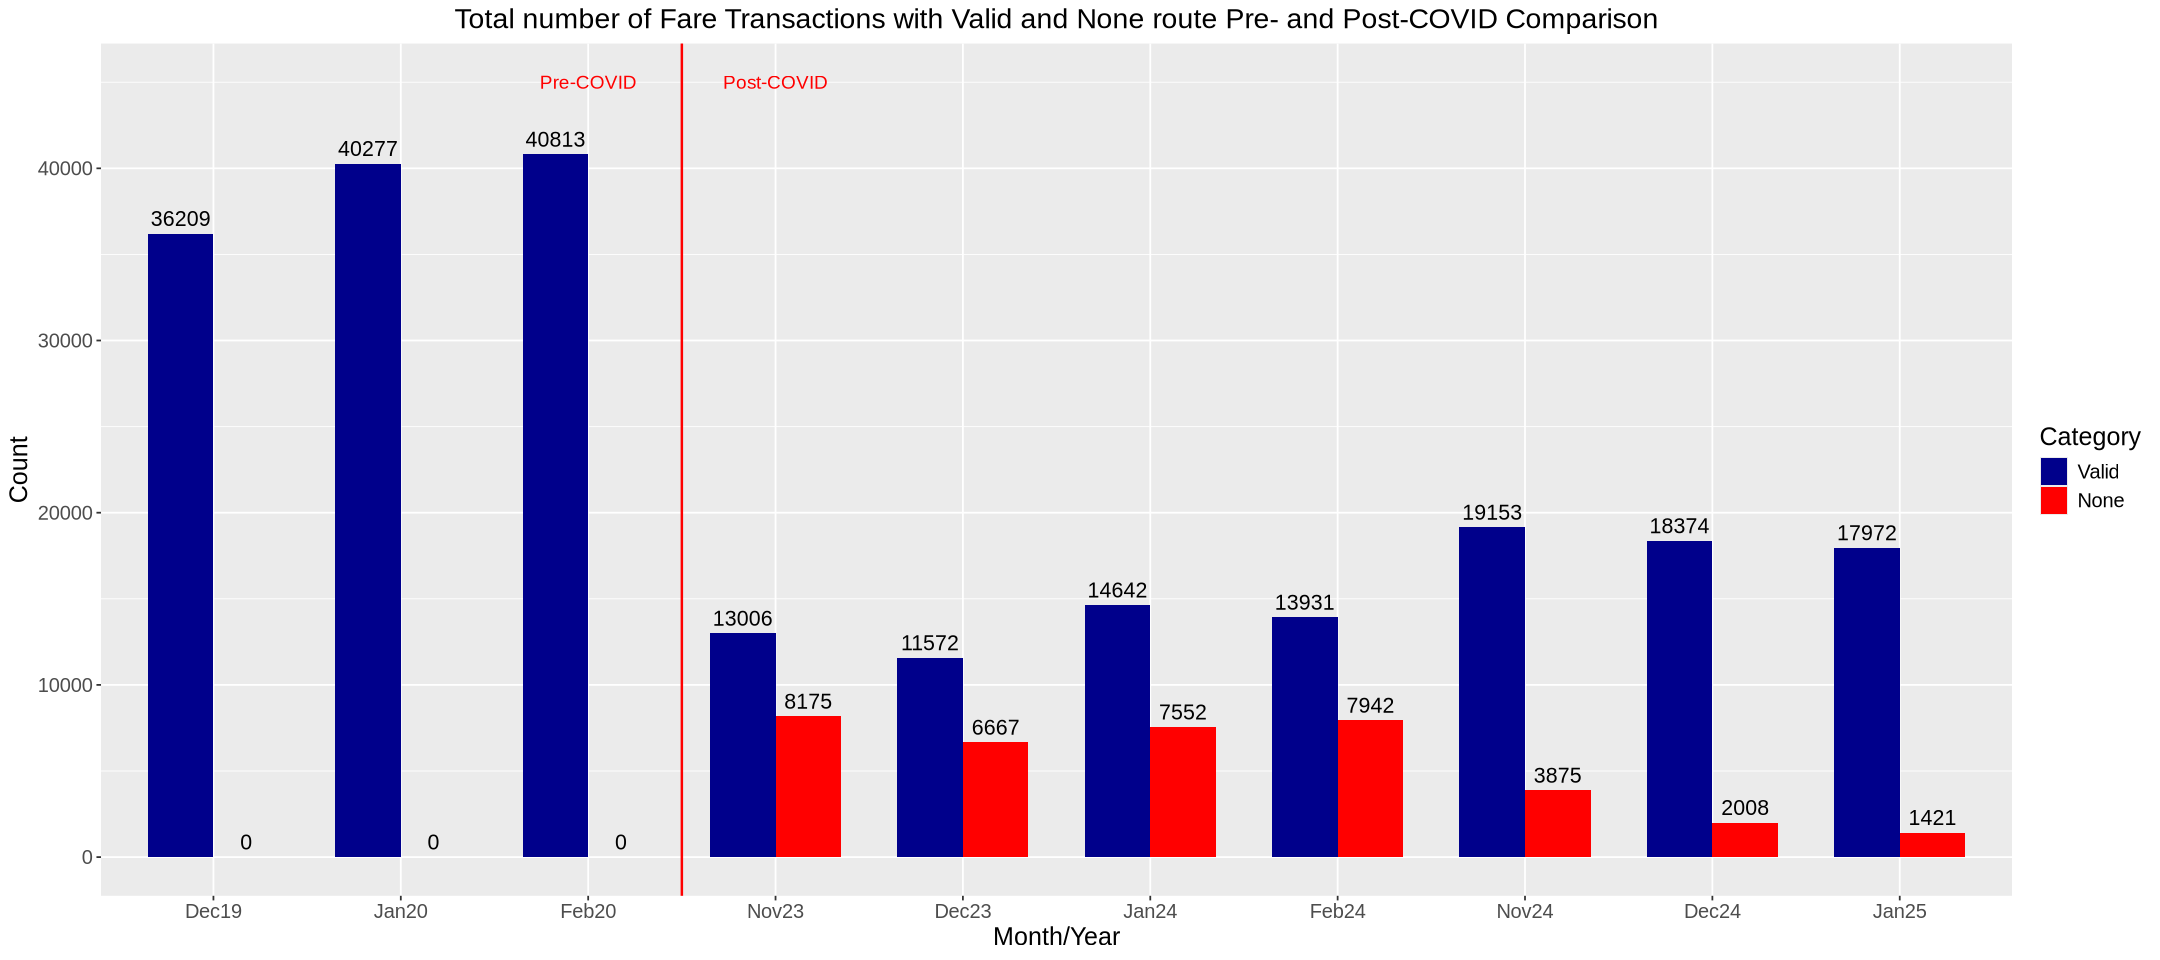

In [124]:
options(repr.plot.width = 18, repr.plot.height =8) 
SolTransAnnual3 %>% 
    select(-dayCount, -Revenue, -Loss) %>% 
    mutate(Month = factor(Month, levels = pull(SolTransAnnual3, Month))) %>% 
    pivot_longer(!Month, names_to = "Category", values_to = "Count") %>% 
    mutate(Category = factor(Category, levels = c("Valid", "None"))) %>% 
    ggplot(aes(x = Month, y = Count , fill = Category)) +
    geom_bar (stat="identity", position ="dodge", width = .7) +
    ggtitle("Total number of Fare Transactions with Valid and None route Pre- and Post-COVID Comparison") +
    ylab("Count") +
    xlab("Month/Year")+
    theme(plot.title = element_text(hjust = 0.5, size = 17)) +
    # theme(legend.position = "none") +
    geom_text(
        aes(label=Count), stat = "identity",
        size = 4.5,
        position = position_dodge(0.7),
        vjust = -.5) +
    theme(text = element_text(size = 15),
        axis.text.x = element_text(hjust = 0.5)) +
    scale_fill_manual("Category", values = c("Valid" = "darkblue", "None" = "red")) +
    geom_vline(xintercept = 3.5, color = "red", linewidth = .7) +
    annotate("text", x=3, y=45000, label= paste0("Pre-COVID"), size = 4, color = "red") +
    annotate("text", x=4, y=45000, label= paste0("Post-COVID"), size = 4, color = "red")


In [99]:
sum(SolTransMonth$purseAmount, na.rm = TRUE)

[1] 5538580

In [101]:
nrow(SolTransMonth)

[1] 19393

In [112]:
totalNone

Total,Category
<int>,<chr>
1421,None


In [113]:
validNone

Total,Category
<int>,<chr>
1421,None
19393,Valid


In [117]:
    validNone = totalNone %>%
        add_row(Category = "Valid1", Total  = nrow(SolTransMonth) - totalNone$Total)


In [115]:
validNone

Total,Category
<int>,<chr>
1421,None
17972,Valid1


# Test of Dec2019 one more time 

In [78]:
Month = analyzedMonths$Month[1]
month = analyzedMonths$month[1]
Bus = get(analyzedMonths$Bus[1])

In [80]:
SolTransMonth = read_csv("../fs_kit/data/20241100009.000000.csv", col_select = c(
  operatorId,
  deviceSerialNumber,
  routeId,
  PST,
  recordType,
  contractId,
  purseAmount,
  transferDiscountFlag,
  )
)%>% 
     filter(operatorId == 9,
            recordType == 1,
            # deviceSerialNumber > 7805802,
            # deviceSerialNumber < 7805874
           ) %>% 
     inner_join(Bus1)


head(SolTransMonth)
dim(SolTransMonth)

Rows: 90821 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): PST
dbl (7): operatorId, deviceSerialNumber, routeId, recordType, contractId, pu...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Joining with `by = join_by(deviceSerialNumber)`


operatorId,deviceSerialNumber,routeId,PST,recordType,contractId,purseAmount,transferDiscountFlag,Bus
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
9,7805859,781,10/28/2024 13:02,1,0,250,0,5111
9,7805859,781,10/28/2024 13:49,1,0,500,0,5111
9,7805859,781,10/28/2024 13:50,1,0,250,0,5111
9,7805859,781,10/28/2024 13:53,1,0,500,0,5111
9,7805859,781,10/28/2024 13:58,1,0,250,0,5111
9,7805859,781,10/28/2024 14:17,1,0,500,0,5111


[1] 23028     9

In [88]:
totalLoss = SolTransMonth %>% 
    filter(routeId == 835, 
           # Bus > 5000,
           # contractId == 0,
           # purseAmount != 0,
           # transferDiscountFlag == 0
          ) %>% 
    mutate(Loss = 1.5 * purseAmount) %>% 
    summarise(Total = sum(Loss)/100,
              Number = n()) %>%
    mutate(Category = "Loss")
totalLoss

Total,Number,Category
<dbl>,<int>,<chr>
8304,3173,Loss


In [86]:
SolTransMonth %>% 
    filter(routeId == 835, 
           Bus > 5000,
           contractId == 0,
           purseAmount != 0,
           transferDiscountFlag == 0) %>% 
    mutate(Loss = 1.5 * purseAmount)

operatorId,deviceSerialNumber,routeId,PST,recordType,contractId,purseAmount,transferDiscountFlag,Bus,Loss
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
9,7805859,835,10/30/2024 8:06,1,0,200,0,5111,300
9,7805859,835,10/30/2024 8:09,1,0,200,0,5111,300
9,7805859,835,10/30/2024 8:28,1,0,200,0,5111,300
9,7805859,835,10/30/2024 8:28,1,0,200,0,5111,300
9,7805859,835,10/30/2024 8:39,1,0,200,0,5111,300
9,7805859,835,10/30/2024 8:39,1,0,200,0,5111,300
9,7805859,835,10/30/2024 8:39,1,0,200,0,5111,300
9,7805859,835,10/30/2024 8:55,1,0,200,0,5111,300
9,7805823,835,10/31/2024 5:37,1,0,200,0,5116,300


In [ ]:
revenueLoss = totalLoss %>%
    add_row(Category = "Revenue", Total  = sum(SolTransMonth$purseAmount, na.rm = TRUE)/100)
revenueLoss

In [ ]:
# revenueLoss %>% 
#     mutate(Category = factor(Category, levels = c("Revenue", "Loss"))) %>% 
#     ggplot(aes(x = Category, y = Total , fill = Category)) +
#     geom_bar(stat = "identity") +
#     ggtitle("SolTrans Revenue/Loss in December, 2019") +
#     ylab("Amount ($)") +
#     xlab("Revenue/Loss")+
#     theme(plot.title = element_text(hjust = 0.5, size = 15)) +
#     theme(legend.position = "none") +
#     geom_text(
#         aes(label=Total), stat = "identity",
#         size = 4.5,
#         position = position_dodge(0.9),
#         vjust = -.5) +
#     theme(text = element_text(size = 15),
#         axis.text.x = element_text(hjust = 0.5)) +
#     scale_fill_manual("Category", values = c("Revenue" = "blue", "Loss" = "red")) 
#     # annotate("text", x=2, y=7500, label= paste0("Total Loss = ", sum(X$Fares)), size = 5)


In [ ]:
SolTransAnnual1 = SolTransAnnual1 %>% 
    add_row(Month = Month, Revenue = revenueLoss$Total[2], Loss = revenueLoss$Total[1]) 

SolTransAnnual1